In [1]:
from copy import deepcopy
from itertools import combinations
import typing as tp

import numpy as np
import pandas as pd
from numpy.linalg import lstsq
from scipy.optimize import linprog

from matplotlib import pyplot as plt
from citk.layer import Dense, NeoFuzzyLayer
from citk.model import FFN, GMDH
from citk.functions import ReLU, Linear, BellMembership, GaussianMembership, Poly
from citk.losses import MSE, FMSE
from citk.optimisers import SGDOptimizer

from utils import seed_everything, normalize_df, create_lags

%matplotlib inline

# Data

In [2]:
RANDOM_SEED = 42
N_LAGS = 2
INITIAL_TEST_LEN = 8

seed_everything(RANDOM_SEED)

data = pd.read_csv('../data/data.csv', encoding='cp1251', sep=';', decimal=',').dropna()

train_df, test_df = data.iloc[:-INITIAL_TEST_LEN], data.iloc[-INITIAL_TEST_LEN:]

train_df, test_df = create_lags(
    train_df, test_df, 
    train_df.columns.tolist(), 
    N_LAGS
)

y_col = 'ІСЦ (+1)'
X_col = train_df.columns.tolist()
X_col.remove(y_col)

train_df, test_df = normalize_df(train_df, test_df, X_col)

X_train = train_df[X_col].values
X_test = test_df[X_col].values
y_train = train_df[y_col].values[..., np.newaxis]
y_test = test_df[y_col].values[..., np.newaxis]

/Users/dmytroandrosov/Documents/citk/Neural_Net_Genetic_Alg/examples/utils.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[f'{col}_{sh}'] = train_df.shift(sh)[col]
/Users/dmytroandrosov/Documents/citk/Neural_Net_Genetic_Alg/examples/utils.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f'{col}_{sh}'] = test_df.shift(sh)[col]


# GMDH 

In [34]:
model = GMDH(
            method_type='neo_fuzzy', 
            loss=MSE,
            num_rules=6,
            confidence=0.9,
            num_sgd_rounds=100
        )

In [35]:
model, history  = model.fit(
    (X_train, y_train),
    (X_test, y_test),
    max_gmdh_layers=10,
    n_best_to_take=30,
    verbose=True
)

Training :   0%|          | 0/10 [00:00<?, ?it/s]

One fit:   0%|          | 0/946 [00:00<?, ?it/s]

Layer: 0. Metric: 0.20116973596353663


One fit:   0%|          | 0/435 [00:00<?, ?it/s]

Layer: 1. Metric: 3.4769071339156845


# Predict and Visualise losses

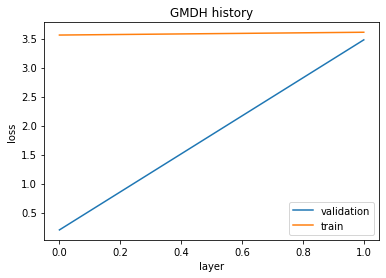

In [36]:
plt.title('GMDH history')
plt.plot(history['validation_loss'], label='validation')
plt.plot(history['train_loss'], label='train')
plt.xlabel('layer')
plt.ylabel('loss')
plt.legend()
plt.show()

In [37]:
prediction = model.predict(X_test)
prediction_train = model.predict(X_train)

In [38]:
print(f"Test MSE: {MSE(y_test, prediction)[0]}")
print(f"Train MSE: {MSE(y_train, prediction_train)[0]}")

Test MSE: 0.20116973596353663
Train MSE: 3.559463330502346


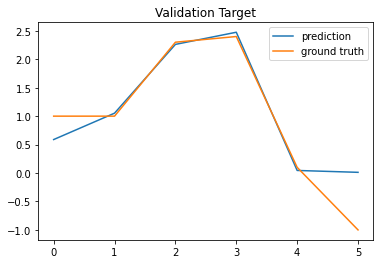

In [39]:
plt.title('Validation Target')
plt.plot(prediction, label='prediction')
plt.plot(y_test, label='ground truth')
plt.legend()
plt.show()

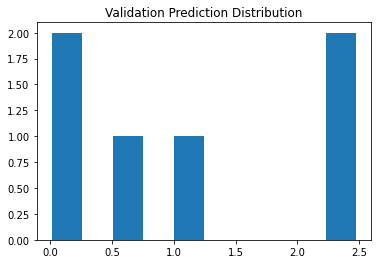

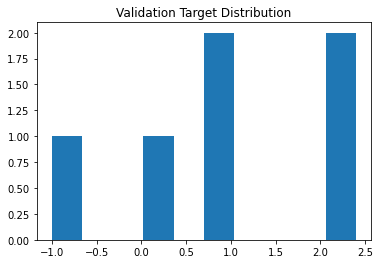

In [40]:
plt.title('Validation Prediction Distribution')
plt.hist(prediction)
plt.show()

plt.title('Validation Target Distribution')
plt.hist(y_test)
plt.show()